<a href="https://colab.research.google.com/github/fsemecurbe/AOTMS/blob/main/AOPTMSG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apply Optimal transport to measure spatial segregation



In [1]:
!pip install POT
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.2 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import pandas as pd
import ot
import numpy as np

In [3]:
carreaux = gpd.read_parquet('/content/drive/MyDrive/aotms/carreaux_200m_met.parquet')
aav2020 = gpd.read_parquet('/content/drive/MyDrive/aotms/aav2020_2024.parquet')

In [4]:
aa = carreaux.sjoin(aav2020[aav2020.libaav2020 == "Besançon"].to_crs(carreaux.crs), how='inner')

In [5]:
aa = carreaux.cx[638036.075463 : 665665.414924,  6851996.452294 : 6874298.045911]
#aa = carreaux.cx[884489.222558:908138.416654 , 6235587.906536:6257320.665661 ]

<Axes: >

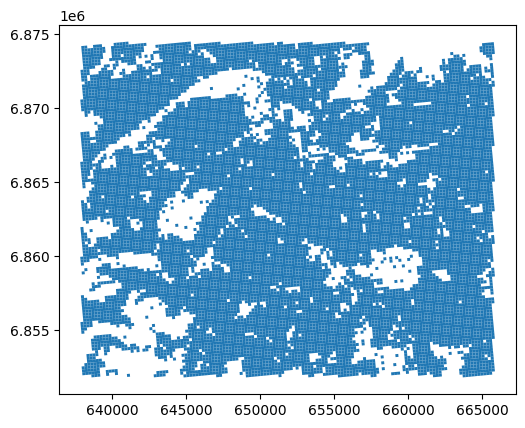

In [6]:
aa.plot()

In [7]:
aa['x'] = aa.geometry.centroid.x
aa['y'] = aa.geometry.centroid.y

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [8]:
aa_poor = aa.loc[aa.men_pauv>0 , ['x','y', 'men_pauv', 'geometry']].rename(columns={'men_pauv':'poor'})
aa['nonpoor'] = aa.men - aa.men_pauv
aa_nonpoor = aa.loc[aa.nonpoor>0  , ['x','y', 'nonpoor', 'geometry']]

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
C = ot.dist(aa_nonpoor[['x', 'y']].to_numpy(), aa_poor[['x', 'y']].to_numpy())

In [ ]:
C

array([[0.00000000e+00, 4.02405547e+04, 2.00399594e+05, ...,
        7.02760300e+08, 6.96697818e+08, 6.90715064e+08],
       [4.02405547e+04, 0.00000000e+00, 1.59482945e+05, ...,
        6.94136599e+08, 6.88073765e+08, 6.82090659e+08],
       [8.04494453e+04, 3.98707656e+04, 3.98707109e+04, ...,
        7.00280734e+08, 6.94138161e+08, 6.88075315e+08],
       ...,
       [7.02760300e+08, 6.94136599e+08, 7.06504623e+08, ...,
        0.00000000e+00, 3.98694062e+04, 1.59477531e+05],
       [6.96697818e+08, 6.88073765e+08, 7.00282309e+08, ...,
        3.98694062e+04, 0.00000000e+00, 3.98693594e+04],
       [6.90715064e+08, 6.82090659e+08, 6.94139723e+08, ...,
        1.59477531e+05, 3.98693594e+04, 0.00000000e+00]])

In [10]:
poor = (aa_poor.poor / aa_poor.poor.sum()).to_numpy()
nonpoor = (aa_nonpoor.nonpoor / aa_nonpoor.nonpoor.sum()).to_numpy()

In [11]:
T = ot.emd(nonpoor , poor , C**.5, numItermax=5000000)

In [12]:
np.sum(T * C**.5)

1774.5415963555374

In [13]:
Cnotnul = C > 0

In [14]:
np.sum(Cnotnul * T,0)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 4.70244348e-06])

In [15]:
aa_poor['dist'] = np.sum(T * C**.5, axis=0) / poor
aa_poor['ratio'] = np.sum(Cnotnul * T,0) / poor
aa_poor['dist_pure'] = np.sum(T * C**.5, axis=0)
aa_nonpoor['dist'] =   np.sum(T * C**.5, axis=1) / nonpoor
aa_nonpoor['dist_pure'] =   np.sum(T * C**.5, axis=1)

In [16]:
np.sum(poor)

0.9999999999999999

In [17]:
np.sum(T.sum(0) - poor)

-3.566262817824781e-17

<Axes: >

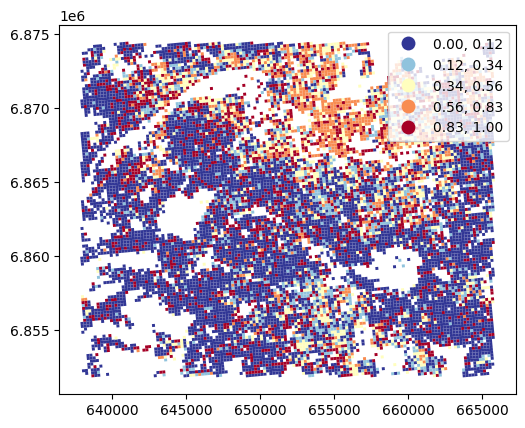

In [19]:
aa_poor.plot('ratio', cmap='RdYlBu_r', scheme='fisherjenks', legend=True )

<Axes: >

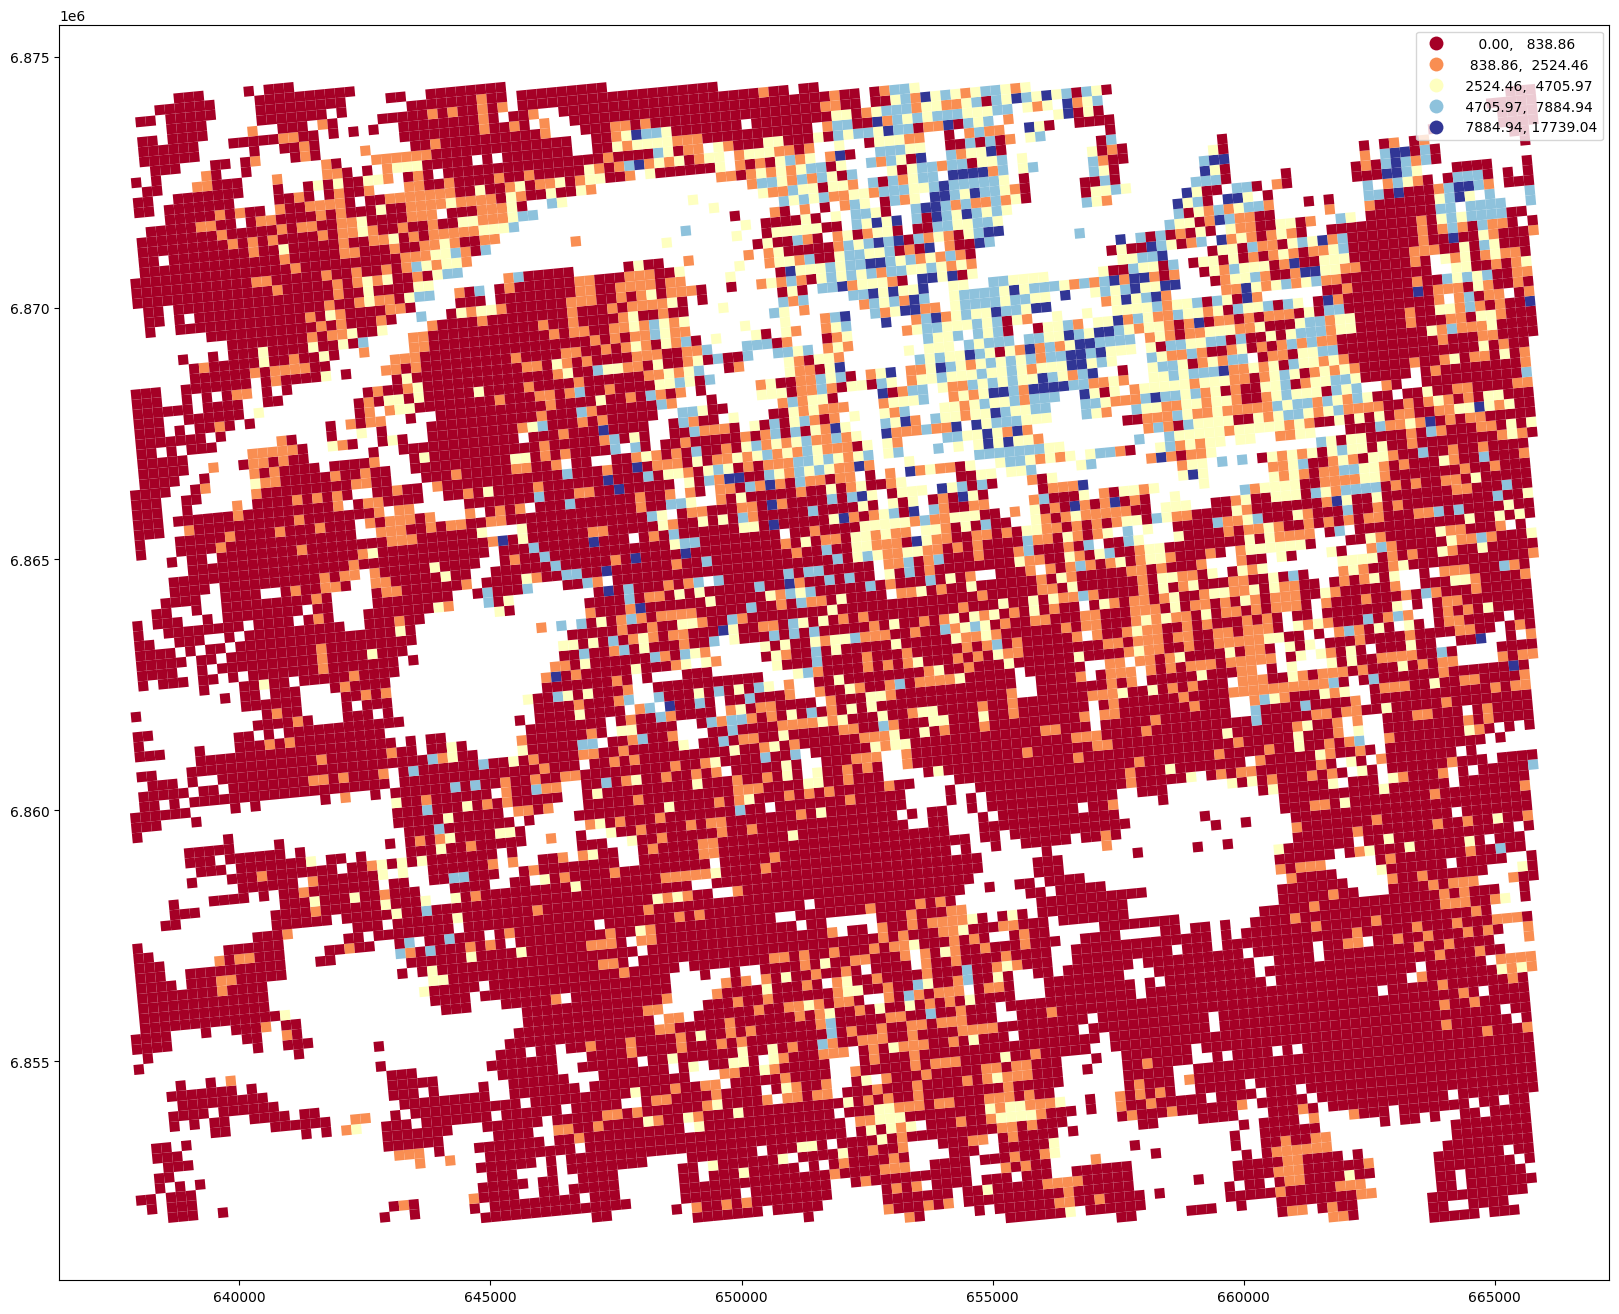

In [20]:
aa_poor.plot('dist', cmap='RdYlBu', scheme='fisherjenks', legend=True, figsize=(20,20) )

<Axes: >

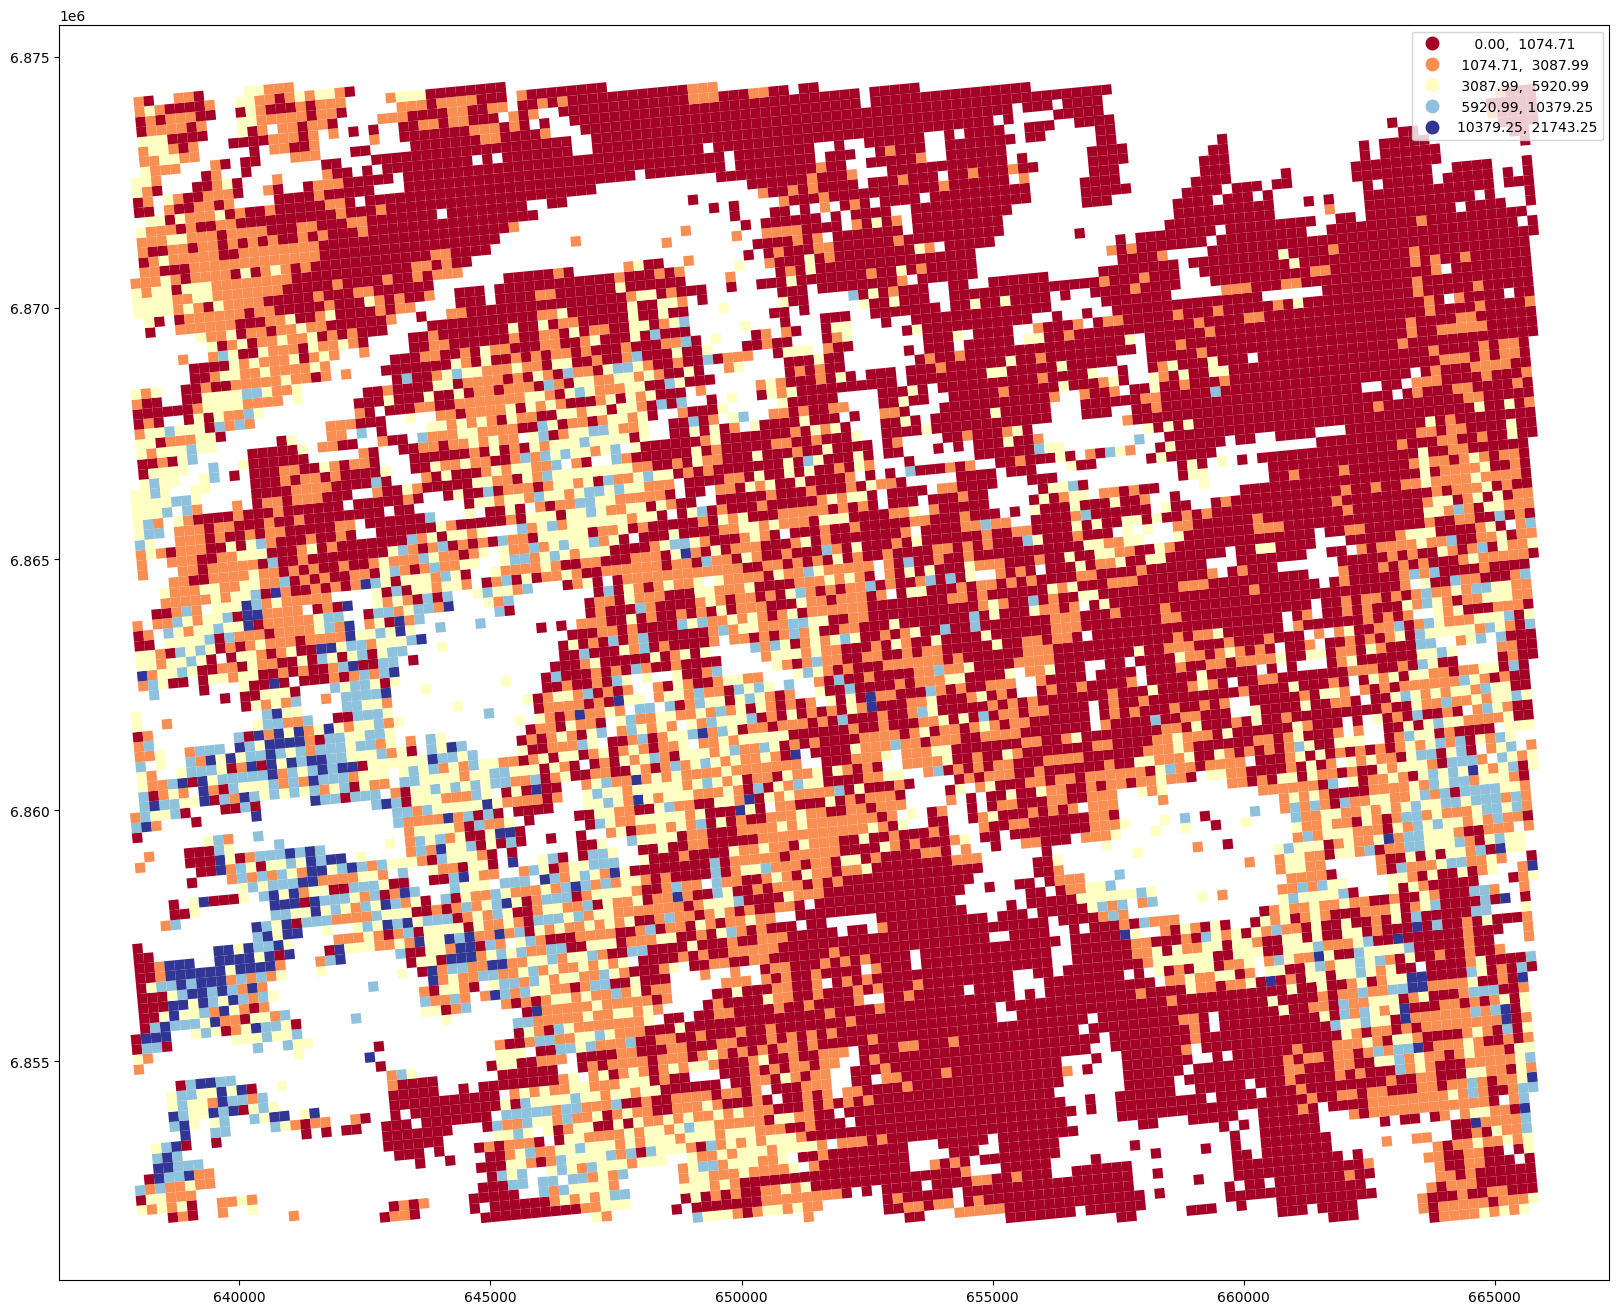

In [21]:
aa_nonpoor.plot('dist', cmap='RdYlBu', scheme='fisherjenks', legend=True ,figsize=(20,20))

on travaille france entière

In [23]:
carreaux['x'] = carreaux.centroid.x
carreaux['y'] = carreaux.centroid.y

In [24]:
carreaux['xround'] = (np.floor(carreaux.x/10000) * 10000).astype(int)
carreaux['yround'] = (np.floor(carreaux.y/10000) * 10000).astype(int)

In [28]:
carreaux_agg = carreaux[['xround', 'yround', 'men', 'men_pauv', 'geometry']].dissolve(by=['xround', 'yround'],as_index=False, aggfunc=np.sum)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:2057: FutureWarning: The provided callable <function sum at 0x7920f4d23370> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc, **kwargs)


In [31]:
france_poor = carreaux_agg.loc[carreaux_agg.men_pauv>0 , ['xround','yround', 'men_pauv', 'geometry']].rename(columns={'men_pauv':'poor'})
carreaux_agg['nonpoor'] = carreaux_agg.men - carreaux_agg.men_pauv
france_nonpoor = carreaux_agg.loc[carreaux_agg.nonpoor>0  , ['xround','yround', 'nonpoor', 'geometry']]

In [34]:
C = ot.dist(france_nonpoor[['xround', 'yround']].to_numpy(), france_poor[['xround', 'yround']].to_numpy())

In [36]:
poor = (france_poor.poor / france_poor.poor.sum()).to_numpy()
nonpoor = (france_nonpoor.nonpoor / france_nonpoor.nonpoor.sum()).to_numpy()

In [37]:
T = ot.emd(nonpoor , poor , C**.5, numItermax=5000000)

In [38]:
france_poor['dist'] = np.sum(T * C**.5, axis=0) / poor

In [ ]:
france_poor.plot('dist', cmap='RdYlBu', scheme='fisherjenks', legend=True, figsize=(20,20) )